## Demo how to use OLR-based MJO index from Kiladis et al 2014 with the DREAM model). 
### Part 2/2.


* stephanie.leroux@ocean-next.fr
* Last update: 5/04/2019 ...
---
#### Purpose: 
* This notebook is the part 2/2 of a demo how to  use  the Original OMI index proposed by Kiladis et al 2014 (see refs below) with the DREAM model
* Part 1/2 ([see here](https://nbviewer.jupyter.org/github/dream-gcm/dream-tools/blob/master/demo_py_notebooks/SLX_MakeNCfromMJO_OMI_EOFs.ipynb)) explained how to read the original txt file from the NOAA ftp and concatenate them in a netcdf file more convenient to read and process, which contains the pair of MJO EOFs for each of the 366 calendar/julian day. [See Part 1/2](https://nbviewer.jupyter.org/github/dream-gcm/dream-tools/blob/master/demo_py_notebooks/SLX_MakeNCfromMJO_OMI_EOFs.ipynb) for more details on the OOMI MJO index.
* Part 2/2 (i.e. this notebook) shows how to read this netcdf file and "customise" the patterns before using with the DREAM model:
---
* Detailed outline of this notebook:  
     1. Read  from file the 366 EOF patterns 
     2. Compute the seasonal average of the EOF pairs for DJF
     3. "Clean" the DJFmean  EOF patterns around central america and africa.
     4. Combine EOF1 and EOF2 in a sequence of 48 days (4xdaily)
     5. Convert the MJO sequence to Gaussian grid
     6. Normalize the sequence (see note just below)
     
---  
* Notes:
     - I chose to "clean" the EOF patterns as follow (but you could easily do differently, or no cleaning at all):
            - EOF1 --> remove any signals between 240º and 340º in longitude, and also remove positive anomalies in the East Pac and over Africa 
            - EOF2 --> remove any signals between 245º and 332.5º in longitude
     - I chose to normalize the sequence by the minimum value of the the patterns of all times (this minimum correspond to the minimum vlaue of the negative anomaly over the maritime continent (i.e. EOF2). Any other choice can be applied below if you wish.

---

### Modules

In [1]:
# modules for dealing nicely with arrays and netcdf
import netCDF4 as nc
import pandas as pd
import os
import xarray as xr
import numpy as np

# third party module i use for resampling on the gaussian grid
# you can install it by running conda install -c conda-forge pyresample in your terminal
import pyresample


# modules for plot purposes
import cartopy.crs as ccrs
import cartopy.feature as ccf
import cartopy.util as ccu
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.colorbar as mcolorbar

# My custom module with plot tools
import utils_SLX_plots_dream as slx


# Only if using jupyter notebook. Otherwise, comment out.
%matplotlib inline 

## Settings

In [2]:
# input/output dir
diri='/Users/leroux/DATA/DREAM_DATA/OMI_EOFpatterns/'

# name of the output file:
fili = 'OMI_EOFs_allyear.nc'

# plot output
diro='/Users/leroux/Desktop/MJOplots/'

---

# 1. Read the 366 EOF patterns

### Read with xarray:

In [3]:
EOF1 = xr.open_dataset(diri+fili,decode_times=True)['eof1']
EOF2 = xr.open_dataset(diri+fili,decode_times=True)['eof2']

### Quick look at what's in the array:

In [4]:
EOF1

<xarray.DataArray 'eof1' (time: 366, lat: 73, lon: 144)>
[3847392 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 -77.5 -75.0 -72.5 ...
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 1980-01-03 ...
Attributes:
    long_name:  EOF1 (OMI)

In [5]:
EOF2

<xarray.DataArray 'eof2' (time: 366, lat: 73, lon: 144)>
[3847392 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 -77.5 -75.0 -72.5 ...
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 1980-01-03 ...
Attributes:
    long_name:  EOF2 (OMI)

### As a check, quick plot of the pair of patterns for a given day:

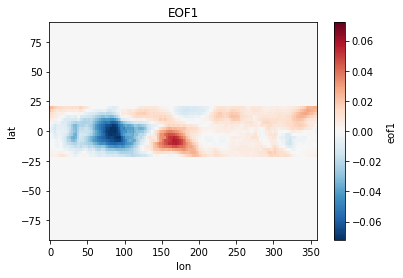

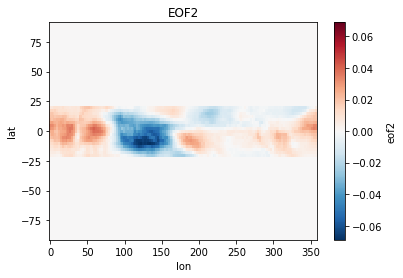

In [7]:
EOF1.sel(time='1980-04-01').plot()
plt.title('EOF1')
plt.show()

EOF2.sel(time='1980-04-01').plot()
plt.title('EOF2')
plt.show()

## Now loop on the 366 days to plot the pair of EOFs for each day (to make a movie):

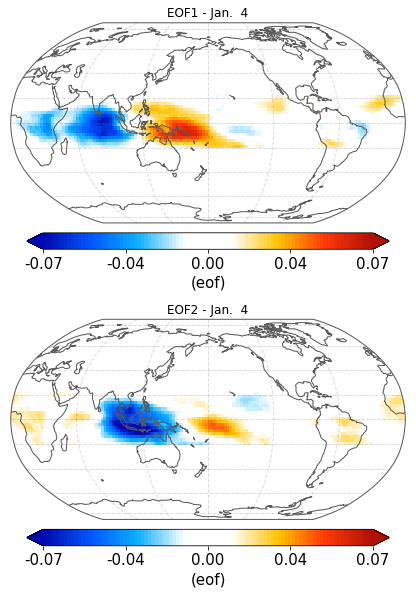

In [8]:
#----------------------------------------------------
#------ PLOT PARAMETERS------------------------------
#----------------------------------------------------

#------------ geography
# Global plot? True/False
glo= True

# center longitude on:
loncentr=180.

# set coastL to True if you want coaslines
coastL=True

#------------ color shading

# type of plot (can be 'contourf', 'pcolormesh', defaut is contourf)
typlo='pcolormesh'

# min max values on the colorscale
vmin=-0.07
vmax=0.07

# colormap
cm_base=slx.make_SLXcolormap(whichco='MJO',reverse=True)

# number of color segments of the colormap
Nincr=100

# color of the values smaller than vmin
su='#EFF5FB'
# color of the values larger than vmax
so='#F8E0E0'
 

# number of labels on the colorbar
Nbar=5

#------------ plot output
# plot format
pltty = ".png"

# plot resolution (dpi)
dpifig=300

# base name for output plot file
plti="OMIEOFs"


# loop on the 366 days
for it in range(0,366):

        # output plot file name including the time index
        plto = plti+"."+str(it+1001)


        # data to plot (must be a 2-d np.array)
        # here we select one timestep at a time for plotting purposes
        data2plot  = EOF1.isel(time=it)
        data2plot2  = EOF2.isel(time=it)

        # colorbar label 
        labelplt='(eof)'

        # make the data to plot cyclic so that the values at longitude 0 are repeated at 360. (for plot purposes)
        # EOF1
        cyclic_data, cyclic_lons = ccu.add_cyclic_point(data2plot.values,data2plot.lon.values)
        # EOF2
        cyclic_data2, cyclic_lons = ccu.add_cyclic_point(data2plot2.values,data2plot2.lon.values)


        #----------------------------------------------------
        #------ PLOT ----------------------------------------
        #----------------------------------------------------

        # create fig
        fig1 = plt.figure(figsize=([13,10]),facecolor='white')


        # plot data (base plot from plotmap functionn defined above)
        cs = slx.plotmap(fig1,cyclic_data,cyclic_lons,data2plot.lat.values,plto,subplt=[2,1,1],cm_base=cm_base,vmin=vmin,vmax=vmax,Nincr=Nincr,glo=glo,coastL=coastL,su=su,so=so,loncentr=loncentr,typlo=typlo,Nbar=Nbar,labelplt=labelplt)

        # add title on plot (date)
        plt.title('EOF1 - '+slx.printdayinyear(EOF1.time.to_index(),it))


        # plot data (base plot from plotmap functionn defined above)
        cs = slx.plotmap(fig1,cyclic_data2,cyclic_lons,data2plot2.lat.values,plto,subplt=[2,1,2],cm_base=cm_base,vmin=vmin,vmax=vmax,Nincr=Nincr,glo=glo,coastL=coastL,su=su,so=so,loncentr=loncentr,typlo=typlo,Nbar=Nbar,labelplt=labelplt)

        # add title on plot (date)
        plt.title('EOF2 - '+slx.printdayinyear(EOF1.time.to_index(),it))



        if it==3:
        # display plot only once in the loop
            plt.show()

        # Save fig in png, resolution dpi
        fig1.savefig(diro+"/"+plto+'.png', facecolor=fig1.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#

        # close fig
        plt.close(fig1)   

---

---

# 2. Compute the seasonal average of the EOF pairs for DJF:

### DJF mean:

In [10]:
# Mean DJF EOF1 pattern
# (for convenience: compute jan, feb, dec means and then concatenate and average)
jan = EOF1.sel(time='1980-01')
feb = EOF1.sel(time='1980-02')
dec = EOF1.sel(time='1980-12')
EOF1_DJFmean = xr.concat([jan,feb,dec],dim='time').mean(dim='time')

# Mean DJF EOF2 pattern
# (for convenience: compute jan, feb, dec means and then concatenate and average)
jan = EOF2.sel(time='1980-01')
feb = EOF2.sel(time='1980-02')
dec = EOF2.sel(time='1980-12')
EOF2_DJFmean = xr.concat([jan,feb,dec],dim='time').mean(dim='time')

### Plot the DJFmean pair of EOFs:
(Using a no-white colorscale to see better how to "clean" the patterns)

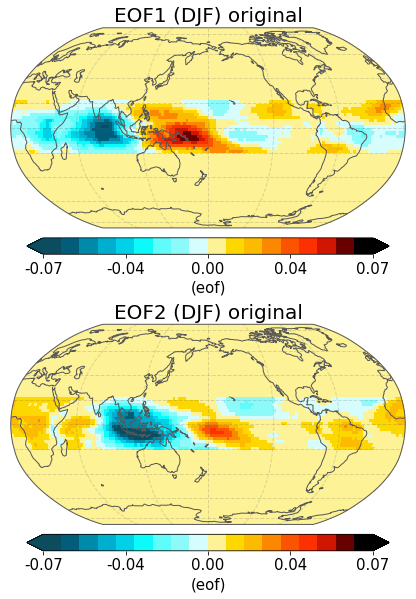

In [12]:
#----------------------------------------------------
#------ PLOT PARAMETERS------------------------------
#----------------------------------------------------

#------------ geography
# Global plot? True/False
glo= True

# center longitude on:
loncentr=180.

# set coastL to True if you want coaslines
coastL=True

#------------ color shading

# type of plot (can be 'contourf', 'pcolormesh', defaut is contourf)
typlo='pcolormesh'

# min max values on the colorscale
vmin=-0.07
vmax=0.07

# colormap
cm_base=slx.make_SLXcolormap(whichco='NCL_NOWI')

# number of color segments of the colormap
Nincr=20

# color of the values smaller than vmin
su='#EFF5FB'
# color of the values larger than vmax
so='#F8E0E0'
 

# number of labels on the colorbar
Nbar=5

#------------ plot output
# plot format
pltty = ".png"

# plot resolution (dpi)
dpifig=300

# base name for output plot file
plti="OMIEOFs_DJFmean_original"

# output plot file name including the time index
plto = plti


# data to plot 
# here we select one timestep for plotting purposes
data2plot  = EOF1_DJFmean 
data2plot2  = EOF2_DJFmean 

# colorbar label 
labelplt='(eof)'

# make the data to plot cyclic so that the values at longitude 0 are repeated at 360. (for plot purposes)
# EOF1
cyclic_data, cyclic_lons = ccu.add_cyclic_point(data2plot.values,data2plot.lon.values)
# EOF2
cyclic_data2, cyclic_lons = ccu.add_cyclic_point(data2plot2.values,data2plot2.lon.values)


#----------------------------------------------------
#------ PLOT ----------------------------------------
#----------------------------------------------------

# create fig
fig1 = plt.figure(figsize=([13,10]),facecolor='white')


# plot data (base plot from plotmap functionn defined above)
cs1 = slx.plotmap(fig1,cyclic_data,cyclic_lons,data2plot.lat.values,plto,subplt=[2,1,1],cm_base=cm_base,vmin=vmin,vmax=vmax,Nincr=Nincr,glo=glo,coastL=coastL,su=su,so=so,loncentr=loncentr,typlo=typlo,Nbar=Nbar,labelplt=labelplt,scattcmap=True)

# add title on plot (date)
plt.title('EOF1 (DJF) original',size=20)


# plot data (base plot from plotmap functionn defined above)
ax = slx.plotmap(fig1,cyclic_data2,cyclic_lons,data2plot2.lat.values,plto,subplt=[2,1,2],cm_base=cm_base,vmin=vmin,vmax=vmax,Nincr=Nincr,glo=glo,coastL=coastL,su=su,so=so,loncentr=loncentr,typlo=typlo,Nbar=Nbar,labelplt=labelplt,scattcmap=True)

# add title on plot (date)
plt.title('EOF2 (DJF) original',size=20)

plt.show()

# Save fig in png, resolution dpi
fig1.savefig(diro+"/"+plto+'.png', facecolor=fig1.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#

# close fig
plt.close(fig1)   

### Look at the min max of each pattern

* EOF1:

In [13]:
print(EOF1_DJFmean.min().values)
print(EOF1_DJFmean.max().values)

-0.06585179743956043
0.060269737945054955


* EOF2:

In [15]:
print(EOF2_DJFmean.min().values)
print(EOF2_DJFmean.max().values)

-0.08226219886813185
0.04205014782417582


---

---

# 3. "Cleaning"

### Proposed cleaning:
    - EOF1 --> remove any signals between 240º and 340º in longitude, and also remove positive anomalies in the East Pac and over Africa 
    - EOF2 --> remove any signals between 245º and 332.5º in longitude

### Clean EOF1_DFJmean: 
(remove any signals between 240º and 340º in longitude, and also remove positive anomalies in the East Pac and over Africa )

In [16]:
select1= EOF1_DJFmean.where((EOF1_DJFmean.lon<=240)|((EOF1_DJFmean.lon>240)&(EOF1_DJFmean<0)),other=0.)  
select2= select1.where((EOF1_DJFmean.lon<=270)|(EOF1_DJFmean.lon>340),other=0.)  
select3= select2.where((EOF1_DJFmean.lon<=210)|((EOF1_DJFmean.lon>210)&(EOF1_DJFmean.lat<0))|((EOF1_DJFmean.lon>210)&(EOF1_DJFmean.lat>=0)&(select2<0)),other=0.)  
select4= select3.where((EOF1_DJFmean.lon>=60)|((EOF1_DJFmean.lon<60)&(select3<0)),other=0.)  
select5= select4.where((EOF1_DJFmean.lon<=245)|((EOF1_DJFmean.lon>245)&(EOF1_DJFmean.lon<300)&(select4>0))|(EOF1_DJFmean.lon>300),other=0.)  

EOF1_DJFmean_cleaned = select5

### Clean EOF2_DFJmean: 
(remove any signals between 245º and 332.5º in longitude)

In [17]:
select1= EOF2_DJFmean.where((EOF2_DJFmean.lon<=245)|((EOF2_DJFmean.lon>245)&(EOF2_DJFmean.lon<332.5)&(EOF2_DJFmean==0))|(EOF2_DJFmean.lon>332.5),other=0.)  
select2= select1.where((EOF2_DJFmean.lon<=332.5)|((EOF2_DJFmean.lon>332.5)&(select1>0.)),other=0.)  

EOF2_DJFmean_cleaned = select2

#### Plot the cleaned patterns to compare with originals

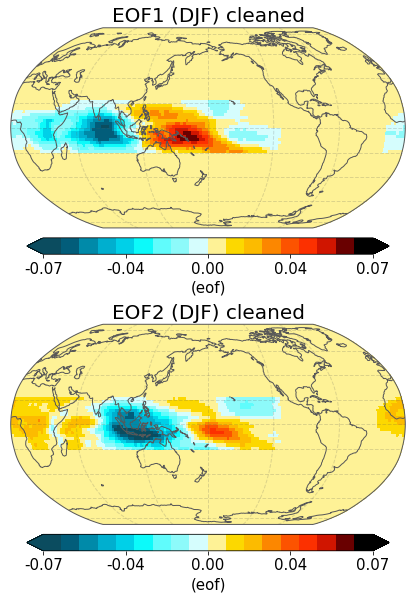

In [18]:
#----------------------------------------------------
#------ PLOT PARAMETERS------------------------------
#----------------------------------------------------

#------------ geography
# Global plot? True/False
glo= True

# center longitude on:
loncentr=180.

# set coastL to True if you want coaslines
coastL=True

#------------ color shading

# type of plot (can be 'contourf', 'pcolormesh', defaut is contourf)
typlo='pcolormesh'

# min max values on the colorscale
vmin=-0.07
vmax=0.07

# colormap
cm_base=slx.make_SLXcolormap(whichco='NCL_NOWI')

# number of color segments of the colormap
Nincr=20

# color of the values smaller than vmin
su='#EFF5FB'
# color of the values larger than vmax
so='#F8E0E0'
 

# number of labels on the colorbar
Nbar=5

#------------ plot output
# plot format
pltty = ".png"

# plot resolution (dpi)
dpifig=300

# base name for output plot file
plti="OMIEOFs_DJFmean_cleaned"

# output plot file name including the time index
plto = plti


# data to plot 
# here we select one timestep for plotting purposes
data2plot   = EOF1_DJFmean_cleaned
data2plot2  = EOF2_DJFmean_cleaned 

# colorbar label 
labelplt='(eof)'

# make the data to plot cyclic so that the values at longitude 0 are repeated at 360. (for plot purposes)
# EOF1
cyclic_data, cyclic_lons = ccu.add_cyclic_point(data2plot.values,data2plot.lon.values)
# EOF2
cyclic_data2, cyclic_lons = ccu.add_cyclic_point(data2plot2.values,data2plot2.lon.values)


#----------------------------------------------------
#------ PLOT ----------------------------------------
#----------------------------------------------------

# create fig
fig1 = plt.figure(figsize=([13,10]),facecolor='white')


# plot data (base plot from plotmap functionn defined above)
cs1 = slx.plotmap(fig1,cyclic_data,cyclic_lons,data2plot.lat.values,plto,subplt=[2,1,1],cm_base=cm_base,vmin=vmin,vmax=vmax,Nincr=Nincr,glo=glo,coastL=coastL,su=su,so=so,loncentr=loncentr,typlo=typlo,Nbar=Nbar,labelplt=labelplt,scattcmap=True)

# add title on plot (date)
plt.title('EOF1 (DJF) cleaned',size=20)


# plot data (base plot from plotmap functionn defined above)
ax = slx.plotmap(fig1,cyclic_data2,cyclic_lons,data2plot2.lat.values,plto,subplt=[2,1,2],cm_base=cm_base,vmin=vmin,vmax=vmax,Nincr=Nincr,glo=glo,coastL=coastL,su=su,so=so,loncentr=loncentr,typlo=typlo,Nbar=Nbar,labelplt=labelplt,scattcmap=True)

# add title on plot (date)
plt.title('EOF2 (DJF) cleaned',size=20)

plt.show()

# Save fig in png, resolution dpi
fig1.savefig(diro+"/"+plto+'.png', facecolor=fig1.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#

# close fig
plt.close(fig1)   

### Look at the min max of each cleaned pattern

* EOF1:

In [19]:
print(EOF1_DJFmean_cleaned.min().values)
print(EOF1_DJFmean_cleaned.max().values)

-0.06585179743956043
0.060269737945054955


* EOF2:

In [20]:
print(EOF2_DJFmean_cleaned.min().values)
print(EOF2_DJFmean_cleaned.max().values)

-0.08226219886813185
0.04205014782417582


---

---

# 4. Combine EOF1 and EOF2 in a sequence of 48 days (4xdaily)

* The code below combines the two EOFs with:

    ``` mjo[ith,:,:] = COS((2.*PI)*(ith/T)))*eof1[ith,:,:] +SIN((2.*np.pi)*(ith/T)))*eof2[ith,:,:]```
    
 where ```ith``` is the time index (4x-daily) and ```T``` is the period (48-days x 4 hours daily).
        
* Note that in this formula, the 2 patterns are equally weighted. According to Kiladis et al 2014, EOF1 explains at most 5-10% more variance than EOF2 so equal weights is ok. But you could easily  adjust the formula to take into account different weights if needed.

* Also note that i made the choice to normalize the final sequence, once the regridding to a gaussian grid is done, rather than normalizing the patterns. You could easily do differently if needed. 

### Create the time coordinate for the 48 days (4xdaily) of the time sequence

In [22]:
units="hours since 1900-01-01 00:00:0.0"

# this is readable dates to be used in the code below
timdim_out = pd.date_range(start='1980-01-01', end='1980-02-18',freq='6H')[:-1]

# this is the conversion of the above for writing the final netcdf file in the right time format
timedimnum_out= nc.date2num(timdim_out.to_pydatetime(),units,calendar='standard')

In [23]:
timdim_out.shape

(192,)

### Ducplicate the two EOF patterns as many times as needed for the time sequence 

(here: 48*4 for a sequence of 48 days with 6h-data)

Note: Have to duplicate numpy array and then form back the xarray with metadata

In [24]:
temp = np.resize(EOF1_DJFmean_cleaned.values,(timdim_out.size,73,144))    
EOF1_long = xr.DataArray(temp, coords=[timdim_out, EOF1_DJFmean_cleaned.lat, EOF1_DJFmean_cleaned.lon], dims=['time','lat', 'lon'], name='eof1_c')

temp = np.resize(EOF2_DJFmean_cleaned.values,(timdim_out.size,73,144))    
EOF2_long=xr.DataArray(temp, coords=[timdim_out, EOF2_DJFmean_cleaned.lat, EOF2_DJFmean_cleaned.lon], dims=['time','lat', 'lon'], name='eof1_c')


### Combine EOF1 and EOF2 with the cos & sin formula below, and store result in ```mjo```
Note: have to work with numpy arrays and form back th exarray at the end

In [25]:
#intitialize
mjotmp  = EOF1_long.values
eof1    = EOF1_long.values
eof2    = EOF2_long.values

# period in days*freq 
# note!!! Don't forget the point to mean they are floats, otherwise, it's considered integers and the formula below fails
T = 48.*4.

for ith in np.arange(0,int(T)):
    th=ith/4.
    mjotmp[ith,:,:] = (np.cos((2.*np.pi)*(ith/T)))*eof1[ith,:,:] +(np.sin((2.*np.pi)*(ith/T)))*eof2[ith,:,:]

# add time
mjo=xr.DataArray(mjotmp, coords=[timedimnum_out, EOF1_long.lat, EOF1_long.lon], dims=['time','lat', 'lon'], name='mjo')
mjo.time.attrs['units']=units
mjo.time.attrs['calendar']='gregorian'

### Write out the MJO sequence. Note that at this stage, it is on a regular 2.5x2.5 grid. And it is not yet normalized.

In [27]:
mjo.to_netcdf(diro+'MJOseq_T48d_4xdaily_reggrid.nc',mode='w')


### Read the MJO sequence again from file

In [28]:
MJO_read = xr.open_dataset(diro+'MJOseq_T48d_4xdaily_reggrid.nc',decode_times=True)['mjo']


### Plot each time step of the sequence (48 day x 4xdaily) to make a movie

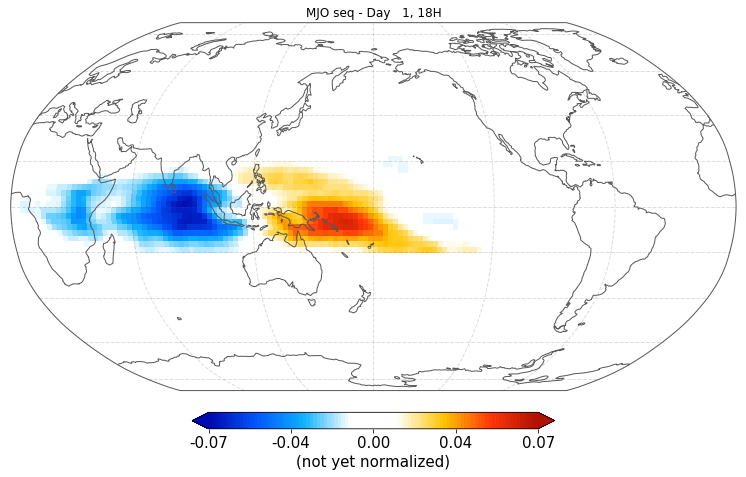

In [60]:
#----------------------------------------------------
#------ PLOT PARAMETERS------------------------------
#----------------------------------------------------

#------------ geography
# Global plot? True/False
glo= True

# center longitude on:
loncentr=180.

# set coastL to True if you want coaslines
coastL=True

#------------ color shading

# type of plot (can be 'contourf', 'pcolormesh', defaut is contourf)
typlo='pcolormesh'

# min max values on the colorscale
vmin=-0.07
vmax=0.07

# colormap
cm_base=slx.make_SLXcolormap(whichco='MJO',reverse=True)

# number of color segments of the colormap
Nincr=100

# color of the values smaller than vmin
su='#EFF5FB'
# color of the values larger than vmax
so='#F8E0E0'
 

# number of labels on the colorbar
Nbar=5

#------------ plot output
# plot format
pltty = ".png"

# plot resolution (dpi)
dpifig=300

# base name for output plot file
plti="MJOseq_reggrid"


# loop on the sequence
for it in range(0,MJO_read.time.size):
#for it in range(0,4):

        # output plot file name including the time index
        plto = plti+"."+str(it+1001)


        # data to plot (must be a 2-d np.array)
        # here we select one timestep at a time for plotting purposes
        data2plot  = MJO_read.isel(time=it)


        # colorbar label 
        labelplt='(not yet normalized)'

        # make the data to plot cyclic so that the values at longitude 0 are repeated at 360. (for plot purposes)
        # EOF1
        cyclic_data, cyclic_lons = ccu.add_cyclic_point(data2plot.values,data2plot.lon.values)


        #----------------------------------------------------
        #------ PLOT ----------------------------------------
        #----------------------------------------------------

        # create fig
        fig1 = plt.figure(figsize=([13,10]),facecolor='white')


        # plot data (base plot from plotmap functionn defined above)
        cs = slx.plotmap(fig1,cyclic_data,cyclic_lons,data2plot.lat.values,plto,cm_base=cm_base,vmin=vmin,vmax=vmax,Nincr=Nincr,glo=glo,coastL=coastL,su=su,so=so,loncentr=loncentr,typlo=typlo,Nbar=Nbar,labelplt=labelplt)

        # add title on plot (date)
        plt.title('MJO seq - '+slx.printdayofyearwthtime(MJO_read.time.to_index(),it))


        if it==3:
        # display plot only once in the loop
            plt.show()

        # Save fig in png, resolution dpi
        fig1.savefig(diro+"/"+plto+'.png', facecolor=fig1.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#

        # close fig
        plt.close(fig1)   

---

---

# 5. Convert to Gaussian grid

### Grid conversion

* Source grid (regular 2.5x2.5)

In [32]:
#  make lat and lon 2-d arrays 
# with  lon from -180 to 180 because the interpolation function below needs it.
# Note that latitudes are from south to north
lon2d, lat2d = np.meshgrid(MJO_read.lon.values-180., MJO_read.lat.values)

* Targeted gaussian grid:

In [33]:
lon_gaussian = np.linspace(0, 360.,endpoint=True, num=129)

* Gaussian latitudes

In [35]:
# T42       
lat_gaussian_half = np.array([87.8638,  85.0965,  82.3129,  79.5256,  76.7369,  73.9475,   71.1577,  68.3678,  65.5776,  62.7873,  59.9970,  57.2066, 54.4162,  51.6257,  48.8352,  46.0447,  43.2542,  40.4636,37.6731,  34.8825,  32.0919,  29.3014,  26.5108,  23.7202,20.9296,  18.1390,  15.3484,  12.5578,   9.7671,   6.9765,4.1859,   1.3953 ])
# latitudes from south to north
lat_gaussian = np.append(-1.*lat_gaussian_half,lat_gaussian_half[::-1])

In [36]:
lat_gaussian

array([-87.8638, -85.0965, -82.3129, -79.5256, -76.7369, -73.9475,
       -71.1577, -68.3678, -65.5776, -62.7873, -59.997 , -57.2066,
       -54.4162, -51.6257, -48.8352, -46.0447, -43.2542, -40.4636,
       -37.6731, -34.8825, -32.0919, -29.3014, -26.5108, -23.7202,
       -20.9296, -18.139 , -15.3484, -12.5578,  -9.7671,  -6.9765,
        -4.1859,  -1.3953,   1.3953,   4.1859,   6.9765,   9.7671,
        12.5578,  15.3484,  18.139 ,  20.9296,  23.7202,  26.5108,
        29.3014,  32.0919,  34.8825,  37.6731,  40.4636,  43.2542,
        46.0447,  48.8352,  51.6257,  54.4162,  57.2066,  59.997 ,
        62.7873,  65.5776,  68.3678,  71.1577,  73.9475,  76.7369,
        79.5256,  82.3129,  85.0965,  87.8638])

* Targetd gaussian grid 2-d

In [37]:
#  make lat and lon 2-d arrays 
lon_gauss2d, lat_gauss2d = np.meshgrid(lon_gaussian-180., lat_gaussian)

* Prepare the data resampling from regular to gaussian grid

In [38]:
orig_def = pyresample.geometry.SwathDefinition(lons=lon2d, lats=lat2d)
targ_def = pyresample.geometry.SwathDefinition(lons=lon_gauss2d, lats=lat_gauss2d)

* Create and compute the final data array of the MJO sequence on the gaussian grid:

In [39]:
arrayM_gauss = np.zeros([mjo.time.size,lat_gaussian.size, lon_gaussian.size])

for ith in np.arange(0,mjo.time.size):
    
    # read array for this time step and make llongitudes -180 to 180
    inputarrayM  = np.array(MJO_read[ith,:,:].values)

    inputarrayM[:,0:72]  = np.array(MJO_read[ith,:,72::].values)
    inputarrayM[:,72::]  = np.array(MJO_read[ith,:,0:72].values)
    
    arrayM_gauss[ith,:,:] = pyresample.kd_tree.resample_gauss(orig_def, inputarrayM, \
                           targ_def, radius_of_influence=500000, neighbours=10,\
                           sigmas=250000, fill_value=None) 


/Users/leroux/anaconda2/envs/py35/lib/python3.5/site-packages/pyresample/kd_tree.py:382: UserWarning: Possible more than 10 neighbours within 500000 m for some data points
  (neighbours, radius_of_influence))


* Reorder longitude so that its 0-360 again

In [41]:
arrayM_gauss_360 = np.zeros([mjo.time.size,lat_gaussian.size, lon_gaussian.size-1])
arrayM_gauss_360[:,:,0:64]  = arrayM_gauss[:,:,64:128]
arrayM_gauss_360[:,:,64::]  = arrayM_gauss[:,:,0:64]

### Create final output (MJO sequence on gaussian grid)

In [42]:
mjo_gauss_out=xr.DataArray(arrayM_gauss_360, coords=[timedimnum_out, lat_gaussian, lon_gaussian[0:128]], dims=['time','lat', 'lon'], name='mjo')

mjo_gauss_out.time.attrs['units']=units
mjo_gauss_out.time.attrs['calendar']='gregorian'

mjo_gauss_out.lat.attrs['units']='degrees_north'
mjo_gauss_out.lat.attrs['long_name']='Latitude'
mjo_gauss_out.lat.attrs['axis']='Y'

mjo_gauss_out.lon.attrs['units']='degrees_east'
mjo_gauss_out.lon.attrs['long_name']='Longitude'
mjo_gauss_out.lon.attrs['axis']='X'

---

---

# 6. Normalize the sequence

* Choice: Here I chose to normalize the sequence by the minimum value of the the patterns of all times (this minimum correspond to the minimum vlaue of the negative anomaly over the maritime continent (i.e. EOF2). You can see it at DAY 13 (ith=48) of the sequence that the min anomaly that day is -1. Of course any other choice for the normalization can be applied below if you wish.

In [54]:
# the norm i chose:
norm=-1.*(1/mjo_gauss_out.min().values)

# applying to the sequence
mjo_gauss_out_norm = norm*mjo_gauss_out

---

---

# 7. Write out final output

In [55]:
mjo_gauss_out_norm.to_netcdf(diro+'MJOseq_T48d_4xdaily_gaussgridT42.nc',mode='w')

---

---

# 8. Read the final  MJO sequence again from file (as a check) and plot

In [56]:
MJOgauss_read = xr.open_dataset(diro+'MJOseq_T48d_4xdaily_gaussgridT42.nc',decode_times=True)['mjo']

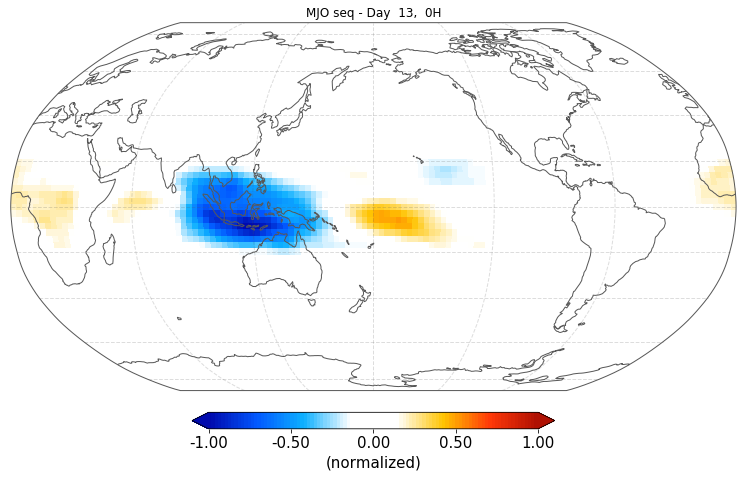

In [59]:
#----------------------------------------------------
#------ PLOT PARAMETERS------------------------------
#----------------------------------------------------

#------------ geography
# Global plot? True/False
glo= True

# center longitude on:
loncentr=180.

# set coastL to True if you want coaslines
coastL=True

#------------ color shading

# type of plot (can be 'contourf', 'pcolormesh', defaut is contourf)
typlo='pcolormesh'

# min max values on the colorscale
vmin=-1.
vmax=1.

# colormap
cm_base=slx.make_SLXcolormap(whichco='MJO',reverse=True)

# number of color segments of the colormap
Nincr=100

# color of the values smaller than vmin
su='#EFF5FB'
# color of the values larger than vmax
so='#F8E0E0'
 

# number of labels on the colorbar
Nbar=5

#------------ plot output
# plot format
pltty = ".png"

# plot resolution (dpi)
dpifig=300

# base name for output plot file
plti="MJOseqgauss"


# loop on the sequence
for it in range(0,MJO_read.time.size):
#for it in range(48,49):

        # output plot file name including the time index
        plto = plti+"."+str(it+1001)


        # data to plot (must be a 2-d np.array)
        # here we select one timestep at a time for plotting purposes
        data2plot  = MJOgauss_read.isel(time=it)


        # colorbar label 
        labelplt='(normalized)'

        # make the data to plot cyclic so that the values at longitude 0 are repeated at 360. (for plot purposes)
        # EOF1
        cyclic_data, cyclic_lons = ccu.add_cyclic_point(data2plot.values,data2plot.lon.values)


        #----------------------------------------------------
        #------ PLOT ----------------------------------------
        #----------------------------------------------------

        # create fig
        fig1 = plt.figure(figsize=([13,10]),facecolor='white')


        # plot data (base plot from plotmap functionn defined above)
        cs = slx.plotmap(fig1,cyclic_data,cyclic_lons,data2plot.lat.values,plto,cm_base=cm_base,vmin=vmin,vmax=vmax,Nincr=Nincr,glo=glo,coastL=coastL,su=su,so=so,loncentr=loncentr,typlo=typlo,Nbar=Nbar,labelplt=labelplt)

        # add title on plot (date)
        plt.title('MJO seq - '+slx.printdayofyearwthtime(MJO_read.time.to_index(),it))


        if it==3:
        # display plot only once in the loop
            plt.show()

        # Save fig in png, resolution dpi
        fig1.savefig(diro+"/"+plto+'.png', facecolor=fig1.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#

        # close fig
        plt.close(fig1)   